In [3]:
if(!require('stats')) {
  install.packages('stats')
  library('stats')
}


In [6]:
# List of required packages
required_packages <- c("seewave", "tuneR", "tidyverse", "audio", "plotly", "fftw", "cowplot", "tuneR", "sonicscrewdriver")

# Function to install and load packages
install_and_load <- function(packages) {
  for (package in packages) {
    if (!require(package, character.only = TRUE)) {
      install.packages(package, dependencies = TRUE)
      library(package, character.only = TRUE)
    }
  }
}

# Suppress messages while loading and installing
suppressMessages({
  install_and_load(required_packages)
})

Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
Warning message:
“package ‘fftw’ was built under R version 4.3.3”


In [7]:
 install.packages('audio')



The downloaded binary packages are in
	/var/folders/xt/4n7p4yn1683_2l9ccdclrfg40000gn/T//Rtmp81ClUD/downloaded_packages


In [8]:
 install.packages('plotly')


The downloaded binary packages are in
	/var/folders/xt/4n7p4yn1683_2l9ccdclrfg40000gn/T//Rtmp81ClUD/downloaded_packages


In [9]:
 install.packages('cowplot')


The downloaded binary packages are in
	/var/folders/xt/4n7p4yn1683_2l9ccdclrfg40000gn/T//Rtmp81ClUD/downloaded_packages


In [ ]:
# Sound Suppression

library(sonicscrewdriver)
library(audio)
library(ggplot2)  # For plotting
library(pracma)   # For FFT and sine wave generation
library(signal)    # For FIR filter design

# Set parameters for recording
sample_rate <- 44100  # Sampling rate in Hz
duration <- 1          # Duration for each recording cycle
buffer_size <- 0.1     # Buffer size in seconds to account for lag
noise_threshold <- 0.05 # Threshold for noise detection (adjust as necessary)
average_factor <- 0.1   # Smoothing factor for averaging
spike_threshold <- 0.1   # Threshold for ignoring spikes (adjust as necessary)

# Calculate the number of samples for the buffer size
buffer_samples <- round(buffer_size * sample_rate)

# Create a circular buffer to hold the last few seconds of audio
audio_buffer <- numeric(buffer_samples)

# Function to calculate RMS
calculate_rms <- function(signal) {
    sqrt(mean(signal^2))
}

# Function to detect the fundamental frequency using FFT
detect_frequency <- function(signal) {
    fft_result <- fft(signal)
    freq <- seq(0, length(fft_result) - 1) * (sample_rate / length(fft_result))
    magnitude <- Mod(fft_result)
    peak_freq <- freq[which.max(magnitude[1:(length(magnitude)/2)])]  # Only consider positive frequencies
    return(peak_freq)
}

# Function to apply a simple low-pass filter
low_pass_filter <- function(signal, cutoff_freq) {
    b <- fir1(128, cutoff_freq / (sample_rate / 2))  # Design a low-pass FIR filter
    filtered_signal <- filter(b, 1, signal)
    return(filtered_signal)
}

# Initialize variables for averaging
previous_noise_level <- 0
average_frequency <- 0
volume_factor <- 1.0

# Start a loop for real-time audio processing
cat("Type 'plot' to see the graphs and 'exit' to exit the program.\n")

while (TRUE) {
    audio_data <- numeric(duration * sample_rate)
    cat("Recording audio... Please speak into the microphone.\n")
    record(audio_data, rate = sample_rate)

    if (inherits(audio_data, "audioSample")) {
        audio_data <- as.numeric(audio_data)
    }

    # Apply low-pass filter to reduce keyboard noise
    filtered_audio_data <- low_pass_filter(audio_data, cutoff_freq = 1000)  # Adjust cutoff frequency as needed

    audio_buffer <- c(audio_buffer, filtered_audio_data)
    audio_buffer <- tail(audio_buffer, buffer_samples)

    noise_level <- calculate_rms(audio_buffer)
    cat(sprintf("Current noise level: %.4f\n", noise_level))  # Output the noise level

    # Ignore sudden spikes in noise
    if (noise_level < spike_threshold) {
        # Detect the fundamental frequency of the noise
        fundamental_freq <- detect_frequency(audio_buffer)
        cat(sprintf("Detected fundamental frequency: %.2f Hz\n", fundamental_freq))

        # Update the average frequency using a simple exponential moving average
        average_frequency <- average_frequency * (1 - average_factor) + fundamental_freq * average_factor

        # Generate a cyclic cancellation wave (sine wave)
        time_axis <- seq(0, duration, by = 1/sample_rate)
        cancellation_wave <- sin(2 * pi * average_frequency * time_axis + pi)  # 180 degrees out of phase

        # Adjust volume based on the noise level
        volume_factor <- ifelse(noise_level > previous_noise_level, 
                                1 + (noise_level - previous_noise_level) * 2, 
                                max(1, volume_factor - 0.1))

        adjusted_audio_data <- cancellation_wave * volume_factor

        # Play the cancellation wave
        play(adjusted_audio_data, rate = sample_rate)
    }

    previous_noise_level <- noise_level

    # Check for user input
    if (interactive()) {
        if (readline("Type 'plot' to see the graphs or 'exit' to stop the program: ") == "plot") {
            cat("Displaying graphs...\n")
            # Plot the waves
            time_axis <- seq(1, length(audio_data)) / sample_rate

            noise_df <- data.frame(time = time_axis, amplitude = audio_data)
            cancellation_df <- data.frame(time = time_axis, amplitude = cancellation_wave)

            # Plot Noise Wave
            ggplot(noise_df, aes(x = time, y = amplitude)) +
                geom_line(color = "blue") +
                labs(title = "Noise Wave", x = "Time (s)", y = "Amplitude") +
                theme_minimal()

            # Plot Cancellation Wave
            ggplot(cancellation_df, aes(x = time, y = amplitude)) +
                geom_line(color = "red") +
                labs(title = "Cancellation Wave", x = "Time (s)", y = "Amplitude") +
                theme_minimal()

            # Plot the Effect of Cancellation
            combined_wave <- audio_data + cancellation_wave
            combined_df <- data.frame(time = time_axis, amplitude = combined_wave)

            ggplot(combined_df, aes(x = time, y = amplitude)) +
                geom_line(color = "green") +
                labs(title = "Combined Effect of Noise and Cancellation", x = "Time (s)", y = "Amplitude") +
                theme_minimal()

            Sys.sleep(5)  # Pause to allow viewing the plots
        }
    }
}


Attaching package: ‘sonicscrewdriver’


The following object is masked from ‘package:base’:

    jitter


Warning message:
“package ‘signal’ was built under R version 4.3.3”

Attaching package: ‘signal’


The following objects are masked from ‘package:pracma’:

    conv, ifft, interp1, pchip, polyval, roots


The following objects are masked from ‘package:stats’:

    filter, poly




Type 'plot' to see the graphs and 'exit' to exit the program.


Recording audio... Please speak into the microphone.
Recording complete.

Wave Object
	Number of Samples:      220500
	Duration (seconds):     5
	Samplingrate (Hertz):   44100
	Channels (Mono/Stereo): Mono
	PCM (integer format):   TRUE
	Bit (8/16/24/32/64):    16 



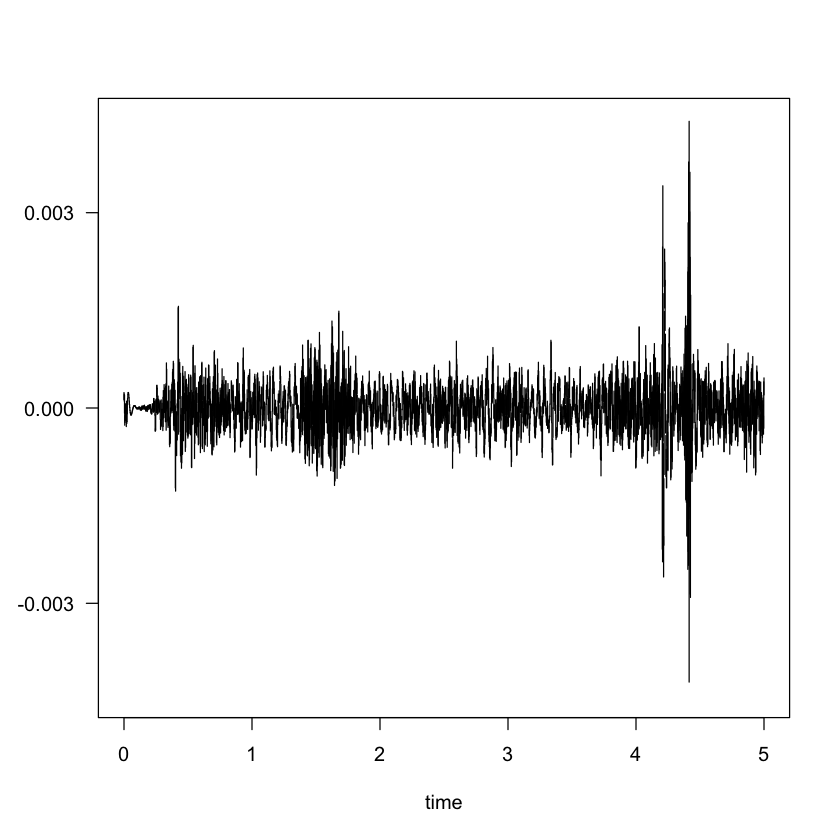

ERROR: Error in play.default(Wobj): LENGTH or similar applied to S4 object


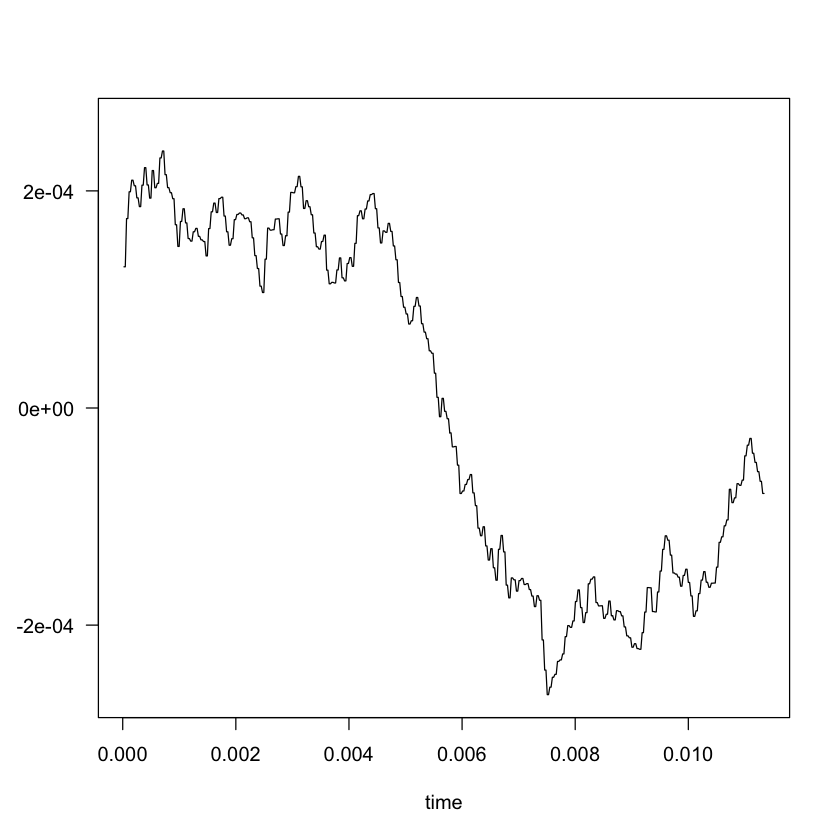

In [25]:

#install.packages("devtools")

#devtools::install_github("edwbaker/SonicScrewdriveR")

suppressMessages({
library(sonicscrewdriver)
#library(tuneR") # in a regular session, we are loading tuneR
#library(plotly)
library(seewave)
library(tuneR)
library(tidyverse)
library(audio)
library(plotly) # for adding some interactivity dust
library(fftw)
library(cowplot)
})



# Set parameters for recording
sample_rate <- 44100  # Sampling rate in Hz
duration <- 5          # Duration in seconds

# Create an empty audio buffer to store the recording
audio_data <- numeric(duration * sample_rate)

# Start recording
cat("Recording audio... Please speak into the microphone.\n")
record(audio_data, rate = sample_rate)


# Wait for the specified duration
Sys.sleep(duration)

# Stop recording
cat("Recording complete.\n")

# Check the class of audio_data
if (inherits(audio_data, "audioSample")) {
    audio_data <- as.numeric(audio_data)  # Convert to numeric if necessary
}

# Create a Wave object from the recorded audio
Wobj <- Wave(left = audio_data, right = numeric(0), samp.rate = sample_rate, bit = 16)
#if (normalise = TRUE) 
#    Wobj <- normalise(audio_data, unit=unit, center=remove.offset)



# constructing a mono Wave object (2 sec.) containing sinus 
# sound with 440Hz and folled by 220Hz:
#Wobj <- bind(sine(440), sine(220))

show(Wobj)
plot(Wobj) # it does not make sense to plot the whole stuff
plot(extractWave(Wobj, from = 1, to = 500))
## Not run: 
play(Wobj) # listen to the sound

## End(Not run)

tmpfile <- file.path(tempdir(), "testfile.wav")
# write the Wave object into a Wave file (can be played with any player):
writeWave(Wobj, tmpfile)
# reading it in again:
Wobj2 <- readWave(tmpfile)

Wobjm <- mono(Wobj, "left") # extract the left channel
# and downsample to 11025 samples/sec.:
Wobjm11 <- downsample(Wobjm, 11025)
# extract a part of the signal interactively (click for left/right limits):
## Not run: 
Wobjm11s <- extractWave(Wobjm11)


## End(Not run)
# or extract some values reproducibly 
Wobjm11s <- extractWave(Wobjm11, from=1000, to=17000)


# Invert the audio data for cancellation
inverted_audio_data <- -1 * Wobjm11s@left  # Invert the left channel

# Create a new Wave object for the cancellation wave
cancellation_wave <- Wave(left = inverted_audio_data, right = numeric(0), 
                          samp.rate = Wobjm11s@samp.rate, bit = 16)

# Play the cancellation wave (optional)
# play(cancellation_wave)  # Uncomment to play the sound

# Save the cancellation wave to a file
cancellation_file <- file.path(tempdir(), "cancellation_wave.wav")
writeWave(cancellation_wave, cancellation_file)

# Print the path to the cancellation wave file
cat("Cancellation wave saved to:", cancellation_file, "\n")

# Plot the cancellation wave
#plot(cancellation_wave, main = "Cancellation Wave", xlab = "Samples", ylab = "Amplitude")

# calculating periodograms of sections each consisting of 1024 observations,
# overlapping by 512 observations:
WspecObject <- periodogram(Wobjm11s, normalize = TRUE, width = 1024, overlap = 512)
# Let's look at the first periodogram:
plot(WspecObject, xlim = c(0, 2000), which = 1)
# or a spectrogram
image(WspecObject, ylim = c(0, 1000))
# calculate the fundamental frequency:
ff <- FF(WspecObject)
print(ff)
# derive note from FF given diapason a'=440
notes <- noteFromFF(ff, 440)
# smooth the notes:
snotes <- smoother(notes)
# outcome should be 0 for diapason "a'" and -12 (12 halftones lower) for "a"
print(snotes) 
# plot melody and energy of the sound:
melodyplot(WspecObject, snotes)

# apply some quantization (into 8 parts): 
qnotes <- quantize(snotes, WspecObject@energy, parts = 8) 
# an plot it, 4 parts a bar (including expected values):
quantplot(qnotes, expected = rep(c(0, -12), each = 4), bars = 2)
# now prepare for LilyPond
qlily <- quantMerge(snotes, 4, 4, 2)
qlily



#print(Wobjm11s )

# read and normalize wav file using tuneR
#data <- tuneR::readWave(Wobjm11s ) %>%
#  tuneR::normalize(unit = c("1"), center = FALSE, rescale = FALSE)
#print(data)


#y = data@left
# defining the window size (number of samples in a 32ms long segment)
#Fs = data@samp.rate
#N <- 32e-3*Fs


#summary(data)


# getting our ggplot on
#theme_set(theme_light())
#wvfm <- ggplot(mapping = aes(x = seq_len(length(y)), y = y))+
#  geom_line(color = 'blue')+
#  labs(x = "Sample Number", y = "Amplitude", title = "Speech waveform")+
#  theme(plot.title = element_text(hjust = 0.5))

#ggplotly(wvfm)


# computing a spectrogram of the audio showing how frequency varies with time
#spect <- ggspectro(y, Fs, wl = N, wn = "hamming", ovlp = 50, fftw = T)+
#  geom_tile(aes(fill = amplitude))+
#  scale_fill_viridis_c()
#ggplotly(spect)





